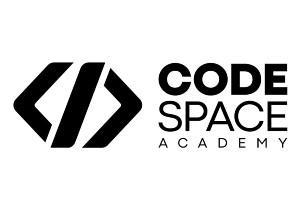

#  **Streamlit** website para predicción de texto
Construcción de una website para pasar noticias de texto y detectar si son verdaderas o falsas noticias.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.8 MB/s eta 0:00:00


## Write file: **App.py**

Para la construcción de este archivo ( requerido para la correcta ejecución del comando de terminal *streamlit run* ) se deberá pasar una cadena de texto válida para la variable **API_URL**. Esta debe ser una URL para hacer solicitudes post al servidor Flask con tunel público de Ngrok que permita, con la ejecución de la función:

      classify_embedding_toAPIPOST

envíar data vectorizada:

    response = requests.post(API_URL, json=data["inputs"][0], headers=HEADERS)

y recibir un string "True" o "False" como respuesta predictiva.

    response_json = response.text
    return response_json

Para la obtención de dicha URL debe ejecutarse previamente el notebook *FAKE-NEWS-CLASSIFICATION* desde la etapa 4 ( conserniente a los experimentos con MLFlow ) en adelante para generar los experimentos, registrar modelos y crear el servidor con flask y Ngrok ( etapa 5 ) que contiene la URL con metodo POST en el path **/invocations**

In [3]:
%%writefile app.py

import streamlit as st
import string
import nltk
from gensim.models import Word2Vec
import numpy as np
import requests
import pickle


nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words = set(stop_words)

EMBEDDING_DIM = 100
API_URL = "https://697c-35-194-229-127.ngrok-free.app/invocations"
HEADERS = {"Content-Type": "application/json"}


# Cargar el modelo de Word2Vec desde el archivo pickle
with open(f"/content/drive/My Drive/CodeSpace_DataScience/FakeNews/word2vec_model.pkl", "rb") as f:
    word2vec_model = pickle.load(f)


def clean_word(word: str) -> str:
    """Remove punctuation and lowercase a word

    Args:
        word (str): the word to clean

    Returns:
        str: the cleaned word
    """
    word = word.lower()
    word = word.strip()

    for letter in word:
        if letter in string.punctuation:
            word = word.replace(letter, '')

    return word


def clean_text(text: str) -> list[str]:
    """Remove stop words and punctioation from a whole text.

    Args:
        text (str): the text to clean

    Returns:
        list[str]: the cleaned text
    """
    clean_text_list = []
    for word in text.split():
        cleaned_word = clean_word(word)
        if cleaned_word not in stop_words:
            clean_text_list.append(cleaned_word)

    return clean_text_list


def vectorize_text(text: list[str]) -> np.ndarray:
    """Vectorize a text by doing a sumatory of the word vectors

    Args:
        text (str): the text to vectorize

    Returns:
        np.ndarray: the vectorized text
    """
    text_vector = np.zeros(EMBEDDING_DIM, np.float32)
    for word in text:
        try:
            word_vector = word2vec_model.wv[word]
        except KeyError:
            st.warning(f"Word {word} not in vocabulary")
            continue
        text_vector += word_vector  # equivalent to text_vector = text_vector + word_vector

    text_vector/=len(text) #(avg)
    return text_vector


def classify_embedding_toAPIPOST(embedding: np.ndarray) -> bool:
    """Classify a text by using ML model

    Args:
        embedding (np.ndarray): the vectorized text. Shape (100,)

    Returns:
        bool: True if the text is real, False otherwise
    """
    embedding = np.expand_dims(embedding, axis=0)  # changes from (100,) to (1, 100)s

    data = {
        "inputs": embedding.tolist(),
    }

    response = requests.post(API_URL, json=data["inputs"][0], headers=HEADERS)
    response_json = response.text
    return response_json


st.title("Fake News Detector")
st.subheader("This is fake news Detector, created with machine learning, for the Code-Space institution of Málaga, Spain")

text_to_predict = st.text_area("Enter the new to check if is fake or not.")
button = st.button("Analyze")

if button:

    st.info("Cleaning text...")
    text_to_predict_clean = clean_text(text_to_predict)

    st.info("Vectorizing text...")
    text_to_predict_vectorized = vectorize_text(text_to_predict_clean)

    st.info("Classifying text...")
    is_real = classify_embedding_toAPIPOST(text_to_predict_vectorized)


    if is_real=="True":
        st.error("Take care, this is a Fake New!")
    elif is_real=="False":
        st.success("You can trust in this information (:")
    else:
      st.error("There is a problem with the server")

Writing app.py


* Construido el archivo **app.py** que será ejecutado vía *streamlit run* en el *localhost 8501* con **localtunnel**, el sistema solicitará una clave de acceso ipv4:

In [4]:
! wget -q -O - ipv4.icanhazip.com

104.196.115.58


* Obtenida dicha clave, se procede a ejecutar por terminal la creación y ejecución de la webpage.

In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://104.196.115.58:8501

npx: installed 22 in 5.358s
your url is: https://plenty-tips-fall.loca.lt
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Proyecciones de la **web en producción**:
Capturas de pantalla para casos de predicción afirmativa ( Fake new ) y negativa

* Fake new:

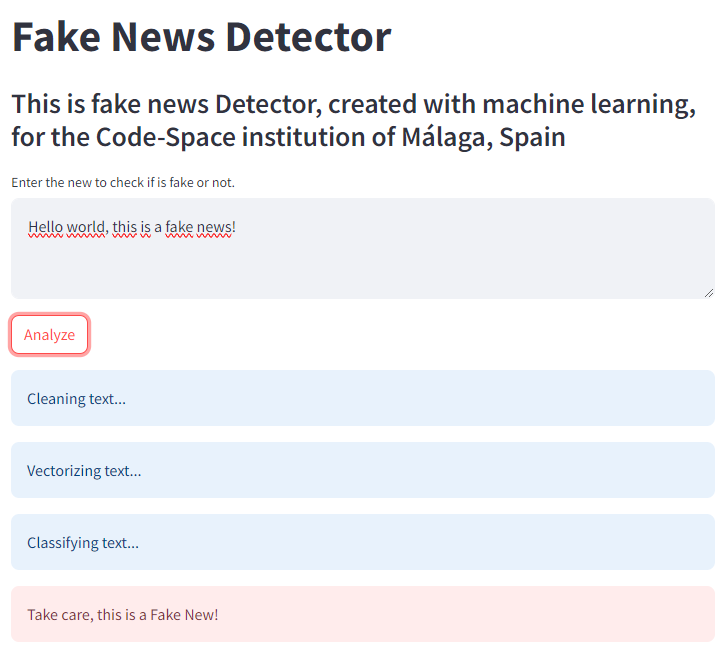

* True new:

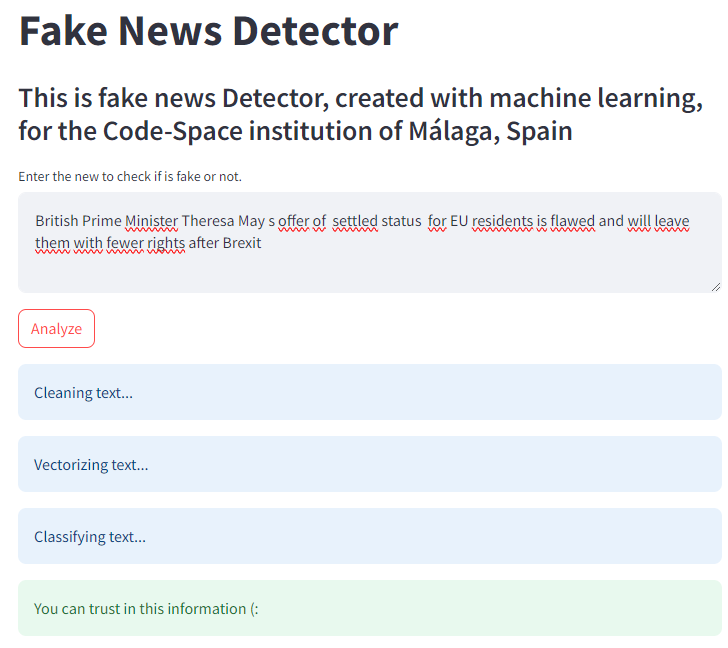